# 測光

**講師:** Chris Copperwheat<br>
**Jupyter Notebook作成者:** Kishalay De & Cameron Hummels

　これは、GROWTH Summer School 2019から取得したJupyter Notebookを使った授業です。他のレッスンとそれに伴う講義については以下を参照ください。 http://growth.caltech.edu/growth-school-2019.html

## 目的
　天文的な紫外線、可視光、赤外線画像データから測光フラックスを測定します。

## 順序
- 画像を補正して、カウントと空の明るさの関係を導き出します。
- 開口測光ツールを使用して、光源の明るさを計算します。
- PSF測光ツールを使用して、光源の明るさを計算します。

## 必要なモジュール

  これらのモジュールとパッケージをインストールする方法の詳細な手順については、GROWTHスクールのWebページを参照してください。 通常、`pip install <module>`でpythonモジュールをインストールできるはずです。外部の天文パッケージは、パッケージマネージャー（たとえば、`rpm`、` apt-get`）を使用してインストールするのが最も簡単です。

### Pythonモジュール
* python 3
* astropy
* numpy
* matplotlib
* astroquery
* photutils

### 外部パッケージ
* SExtractor https://www.astromatic.net/software
* PSFex https://www.astromatic.net/software

　まず、必要なモジュールをいくつかインポートするところから始めましょう。

In [40]:
import numpy as np
import numpy.ma as ma
import os
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
import subprocess

## モジュールの確認

　このJupyter Notebookを正しく機能させるには、上記のように、外部ソフトウェアをインストールする必要があります。次の手順では、測光に進む前にこれらが正しくインストールされていることを確認します。

In [3]:
def test_dependency(dep, alternate_name=None):
    """
    外部モジュールをサブプロセスとして実行してテストします
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('sextractor', 'sex'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

sextractor is installed properly as sextractor. OK
psfex is installed properly as psfex. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.


　インポートしたモジュールを使って、補正された画像を表示しましょう。

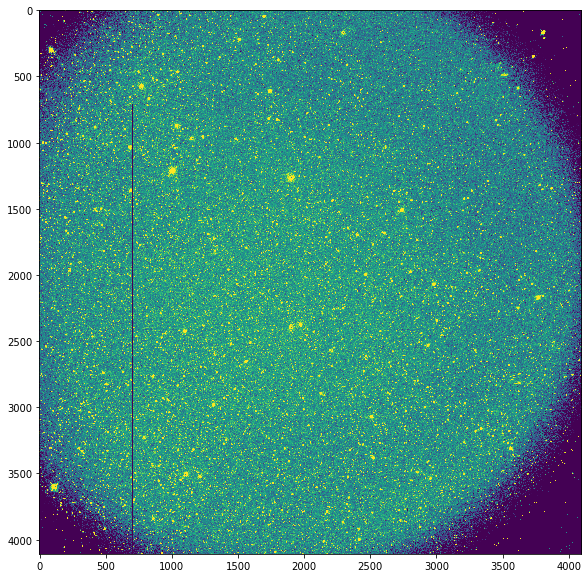

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import os

# データディレクトリに移動します
os.chdir('data')
imageName = 'aC0_20181013-174714-557.wcs.fits.proc.cr.fits'
f = fits.open(imageName)
data = f[0].data  #これが画像を表す行列です
header = f[0].header

#画像プロットをスケーリングするための画像統計を計算します
mean, median, sigma = sigma_clipped_stats(data)

#適切なスケールで画像をプロットします
plt.figure(figsize=(10,10))
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma)
plt.show()

## 外部カタログの取得

　最初のステップでは、測定された等級との比較に必要な画像内の光源の等級のカタログを取得します。このチュートリアルでは、Panstarrs 1（PS1）カタログを参照します。astropyの検索インターフェースである _astroquery_ を使用してPS1を、Vizierサーバーで検索をかけて光源のリストを取得します。まず、画像のヘッダーからこのフィールドの中心座標を知る必要があります。

In [5]:
#strong the image WCS into an object
w = WCS(header)

#画像の中心のRA,Decを取得します
[raImage, decImage] = w.all_pix2world(data.shape[0]/2, data.shape[1]/2, 1)

#ボックスのサイズを設定してカタログ天体を検索します
boxsize = 30 # arcminutes

#Magnitude cut-offs of sources to be cross-matched against
maxmag = 18

　PS1はGROWTH India望遠鏡からの単一の画像よりもはるかに深いため、補正する天体の光度範囲にもカットオフを設定します。この場合は、gバンドで18等の制限等級で十分です。また、PS1の突発増光と可変要素を除去し（PS1調査での検出数のカットオフが必要）、PS1で検出が3σを超える光源のみを選択するため、これらのフィルターをPS1の命令文に組み込みます。

In [41]:
from astroquery.vizier import Vizier
#Vizier.VIZIER_SERVER = 'vizier.ast.cam.ac.uk'

catNum = 'II/349'#VizierでのPS1のカタログ番号
print('\nQuerying Vizier %s around RA %.4f, Dec %.4f with a radius of %.4f arcmin'%(catNum, raImage, decImage, boxsize))

try:
    #Vizier命令文の個々の列（光度範囲、検出数）にフィルターを設定できます
    v = Vizier(columns=['*'], column_filters={"gmag":"<%.2f"%maxmag, "Nd":">6", "e_gmag":"<1.086/3"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra = raImage, dec = decImage, unit = (u.deg, u.deg)), radius = str(boxsize)+'m', catalog=catNum, cache=False)
    #Vizierで半径がboxsizeの（ra、dec）を照会する
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')


Querying Vizier II/349 around RA 324.8076, Dec 46.7254 with a radius of 30.0000 arcmin


/home/fmori/anaconda3/lib/python3.7/site-packages/astroquery/vizier/core.py:717: UserWarning: VOTABLE parsing raised exception: 9541:26: not well-formed (invalid token)
  warnings.warn("VOTABLE parsing raised exception: {0}".format(ex))


I cannnot reach the Vizier database. Is the internet working?


　Vizier検索が実行されなかった場合に備えて（Vizierサーバーの負荷がかかった場合、そうなる可能性があります）、ps1_v641cyg.tabファイルのソーステーブルを読み取ります。上の操作で完了した場合は、この手順を実行する必要はありません。

In [7]:
from astropy.table import Table

Q = [Table.read('ps1_v641cyg.tab')]

print(Q[0])

   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag  yFlags 
     deg           deg                         ...   mag     mag           
------------- ------------- ------------------ ... ------- ------- --------
324.546492510  46.264703470 163513245465168323 ... 16.9685  0.0654   115000
324.530625620  46.266287540 163523245306050216 ... 13.9154  0.0091    16696
324.529447350  46.265017540 163513245294518713 ... 14.1221  0.0034   115000
324.538854840  46.274398210 163523245388569962 ... 15.0640  0.0109   115000
324.528015530  46.275544270 163533245280161337 ... 12.3784  0.0305   115000
324.523853150  46.279186790 163533245238505715 ... 16.5256  0.0110   115000
324.516592810  46.283122040 163543245165700413 ... 14.1370  0.0074   115000
324.512081250  46.287262650 163543245120575404 ... 16.7702  0.0450    16696
324.516398520  46.270782360 163523245164085625 ... 15.8548  0.0072   115000
324.523576670  46.287347280 163543245235585487 ... 15.9542  0.0089   115000
          ..

　検索によって、この画像内で約10,000個のカタログ天体が取得されているはずです。次に、画像の端から離れた星をフィルタリングします（SExtractorで検出された天体の場合と同じ）。以下のコマンドに条件を追加するだけで、カタログ天体にフィルターを追加することもできます。

　画像の中心を見つけるために使用したのと同じ方法を使用して、astropyテーブルのカタログ座標を使用して、天体の画像座標を取得します。次に、good_cat_starsというテーブルを作成して、そこに画像のx方向とy方向の両方のピクセル範囲（500、3500）内の天体のみを格納します。

In [8]:
#天体の世界座標を画像座標に変換します
ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)

#エッジに近い天体を除去するもう1つのフィルタリング
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
print(good_cat_stars)

   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
324.991321070  46.493072460 163793249913192336 ... 15.6587  0.0080 115000
324.995456660  46.491872990 163793249954760916 ... 16.4147  0.0169 115000
324.996154600  46.493197980 163793249960252496 ... 16.6141  0.0074 115000
324.986133270  46.486829770 163783249861224813 ... 16.2165  0.0097 115000
324.990104900  46.484038270 163783249901031502 ... 16.5208  0.0107 115000
324.975856910  46.479822180 163773249758666438 ... 16.0091  0.0101  16696
324.987516640  46.482068620 163773249875209155 ... 15.9656  0.0123 115000
325.029065080  46.500275900 163803250289711054 ... 13.0745  0.0052 115000
325.005109120  46.502755980 163803250051153972 ... 14.2958  0.0108 115000
325.012635110  46.507884270 163813250126600147 ... 16.3732  0.0091 115000
          ...           ...           

　フィルター処理された適切なカタログ天体の画像座標を取得して、画像上にプロットしましょう。

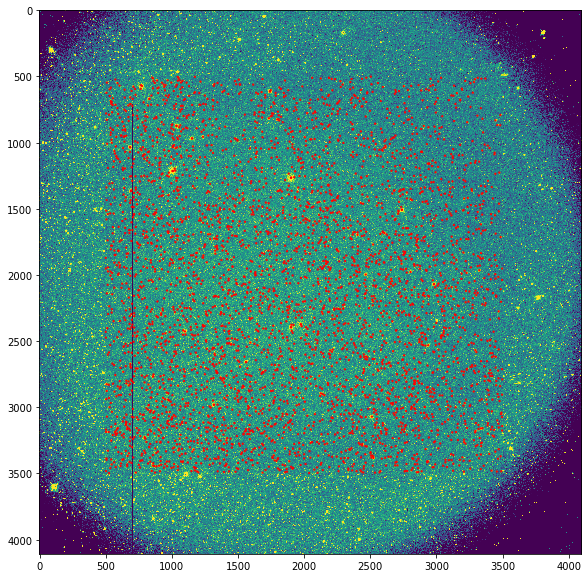

In [9]:
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma)
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 5, edgecolor='r', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

## 開口測光

　開口測光を始めるには、画像の点光源を特定し、その明るさを既知のカタログと比較する必要があります。「Source Extractor」（別名SExtractor）と呼ばれる一般的なコードを使用して、画像内の点光源を検出します。

### 天体検出

　SExtractorは非常に有用なコードであり、広範囲の複雑な天体検出ができますが、構成ファイルとパラメーターファイルを使用して適切な構成を組み、検出する天体の種類と測定するパラメーターを指定する必要があります。

　バックグラウンドからしきい値が10$\sigma$を超える天体を検出し、そのフラックスを測定するように設計された構成ファイルがディレクトリにあります。詳細については後に説明しますが、まずはSExtractorがどのように実行されるかを見てみましょう。

In [10]:
configFile = 'photomCat.sex'
catalogName = imageName+'.cat'
paramName = 'photomCat.param'
try:
    command = 'sextractor -c %s %s -CATALOG_NAME %s -PARAMETERS_NAME %s' % (configFile, imageName, catalogName, paramName)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print('Could not run sextractor with exit error %s'%err)

Executing command: sextractor -c photomCat.sex aC0_20181013-174714-557.wcs.fits.proc.cr.fits -CATALOG_NAME aC0_20181013-174714-557.wcs.fits.proc.cr.fits.cat -PARAMETERS_NAME photomCat.param


　ここでは、 '-c'で指定された構成ファイルを使用してSExtractorを実行し、検出した天体のリストを「FITS LDAC」と呼ばれる形式で「imageName + '.cat'」というファイルに出力するように要求しています。SExtractorによって生成される出力パラメーターは、ファイル「photomCat.param」にあり、「PARAMETERS_NAME」によって指定されます。次に、SExtractorによって作成された天体カタログをastropyテーブルに読み込みます。その前に、astropyでFITS LDACテーブルを読み取る関数があります。

In [11]:
def get_table_from_ldac(filename, frame=1):
    """
    フレームごとにastropyテーブルをfits_ldacから読み込みます
    （ldac形式には奇数テーブルの列情報があるため、通常のfits画像のBinTableHDUの2倍のテーブルを提供するので、
    　テーブルのフレームをldacファイル内の対応するフレームに一致させます）。
        
    Parameters
    ----------
    filename: str
        開くファイルの名前
    frame: int
        通常のfitsファイルのフレーム数
    """
    from astropy.table import Table
    if frame>0:
        frame = frame*2
    tbl = Table.read(filename, hdu=frame)
    return tbl

In [12]:
#SExtractorによって生成されたLDACファイルを読み取るためのPythonラッパー
sourceTable = get_table_from_ldac(catalogName)
#テーブルの中身を見てみましょう
print(sourceTable.colnames)
print(sourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
       VIGNET [27,27]          X_IMAGE   ...   MAGERR_APER [10]  
             ct                  pix     ...         mag         
---------------------------- ----------- ... --------------------
    6.422684 ..     23.85748   1701.0402 ...   0.0002 ..   0.0002
   -5.962967 ..    -12.01412    900.8122 ...   0.0004 ..   0.0006
    -67.4418 ..    -68.55728   3444.9138 ...   0.0019 ..   0.0025
   -81.50293 ..    -73.63473    308.4576 ...   0.0036 ..   0.0068
   0.7086449 ..       -1e+30   1060.0299 ...   0.0169 ..   0.0245
      -1e+30 ..    -38.96884    402.4958 ...   0.0011 ..   0.0017
      -1e+30 ..     -6.65369    972.8544 ...   0.0177 ..   0

　出力テーブルの列に注意してください。重要なのは画像座標で検出された天体の重心を表す「XWIN_IMAGE」と「YWIN_IMAGE」で、「ALPHAWIN_J2000」と「DELTAWIN_J2000」は世界座標での天体重心です。また、固定開口半径で測定された光源の、バックグラウンドを差し引いたフラックス（ 'FLUX_APER'）と固定開口半径の大きさ（ 'MAG_APER'）もあります。

　優れた測光値を計測するために、他の天体と重なっておらず、画像の端から離れている「クリーンな」天体を見つけて、それらの計測値を取得する必要があります。SExtractorの出力には「FLAGS」列があり、FLAGS = 0の、不良ピクセルから遠く他の天体と重なっていない天体を示します（フラグの他の値の意味については、SExtractorのマニュアルを参照してください）。点のような光源を取得するには、画像の端から離れた光源のFWHMを、約2秒角よりも小さくする必要があります。それでは、この条件を満たす天体を選びましょう。

In [13]:
#フィルタリングをして、基準を満たす天体を選びます
cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) &(sourceTable['YWIN_IMAGE']<3500) &(sourceTable['YWIN_IMAGE']>500)]
print(cleanSources)

       VIGNET [27,27]          X_IMAGE   ...   MAGERR_APER [10]  
             ct                  pix     ...         mag         
---------------------------- ----------- ... --------------------
   0.4083939 ..    -8.423717   1175.2430 ...   0.0051 ..   0.0075
    19.19541 ..       1.6245    858.6505 ...   0.0013 ..   0.0019
     -1.4394 ..     -1.99157   2187.9465 ...   0.0028 ..   0.0041
    -10.8727 ..     7.524075   2469.3601 ...   0.0065 ..   0.0095
   -6.925556 ..    -8.525333   2503.7578 ...   0.0168 ..   0.0232
   -3.559719 ..    -0.621067   3035.4197 ...   0.0085 ..   0.0121
    16.81919 ..   -0.6012573   2208.2244 ...   0.0020 ..   0.0030
   -10.60774 ..      9.01561   2436.8604 ...   0.0041 ..   0.0059
   -4.077919 ..    0.2292175   2125.2761 ...   0.0047 ..   0.0068
    24.30497 ..     5.903603    969.0526 ...   0.0010 ..   0.0014
                         ...         ... ...                  ...
    1.790359 ..     30.24825    983.8996 ...   0.0011 ..   0.0017
     -3.84

　次に、これらの検出された天体を縮小画像に重ねて、SExtractorの効果を確認します

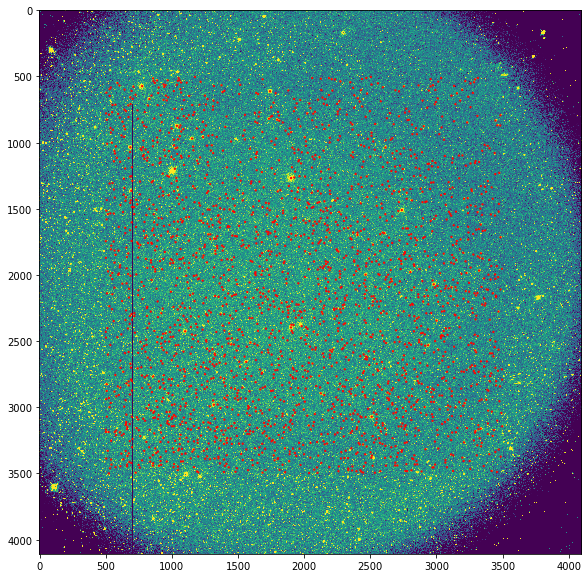

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma)
#検出されたすべて天体の上に円をプロットする
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 5, edgecolor='r', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)


plt.show()

### カタログのクロスマッチング

　これまでの過程で、画像で検出された天体のカタログと、比較する天体の外部カタログを取得しました。次のステップでは、2つのカタログをクロスマッチングし、画像で検出された天体と実際の天体との関連性を見つけます。

In [15]:
sourceCatCoords = SkyCoord(ra=cleanSources['ALPHAWIN_J2000'], dec=cleanSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')

#天体のクロスマッチングを行います

#クロスマッチ距離のしきい値を0.6秒角または約1ピクセルに設定します
photoDistThresh = 0.6
idx_image, idx_ps1, d2d, d3d = ps1CatCoords.search_around_sky(sourceCatCoords, photoDistThresh*u.arcsec)
#idx_imageは一致した天体のsourceCatCoordsへの指標であり、idx_ps1は一致した天体のps1CatCoordsへの指標です

print('Found %d good cross-matches'%len(idx_image))

Found 748 good cross-matches


### ゼロ点の導出

　画像とPS1の間で天体が相互に一致したので、ゼロ点の導出を始められます。天体の測光値は、ゼロ点を介してその物理的な等級に関連付けられていることに注意してください。

<h2> <center>

$m_{app}$ = ZP + $m_{ins}$ <br><br>

$m_{ins} = -2.5 \, \textrm{log} \, (\textrm{Total flux})$

</center></h2>

　天体の測光値が、フラックスの測定方法に依存することは簡単にわかるはずです。これが、まさに測光のさまざまな方法が関係するところです。

　すでに説明したように、開口測光では、一定の開口半径で光源のフラックスを測定します。測定するフラックスの量は、選択した開口部のサイズにも依存します。開口部が大きいほど、PSFから取り込むフラックスが多くなります。同時に、開口部を大きくすると、隣接する光源からの光も取り込む可能性があるため、注意が必要です。

　カタログキャリブレーターとターゲット天体のフラックス測定の整合性を保つために、キャリブレーターとターゲット天体で同じ割合のフラックスが「失われる」ように、同じ開口半径でフラックスを測定する必要があります。 ゼロ点は、カタログと測光値の違いに依存するため、導出するゼロ点は、設定した開口部の大きさの関数になります。したがって、開口部固有のゼロ点を考慮に入れることができます。この例を見てみましょう。

　実際に画像から取得したSExtractorのカタログには、「MAG_APER」で検出された天体の開口測光も含まれているため、作業のほとんどは実は既に行われています。この場合、SExtractorパラメータファイルには、測定したい開口部の直径が4.0ピクセルから13.0ピクセルまで1.0ピクセル間隔で既に指定されています。
 
__Exercise__:SExtractorの構成ファイルを見て、これらの開口サイズが指定されている箇所を探しましょう。

　計測された等級が異なる開口サイズ間でどのように変化するかを確認するために、最大サイズ（13.0ピクセル）で計測された等級と他のすべてのサイズとの違いをプロットします。

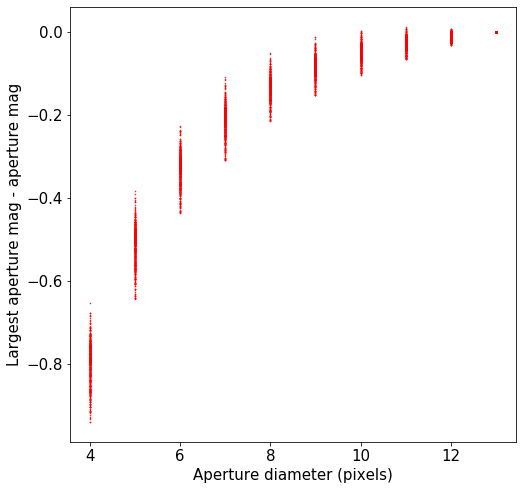

In [16]:
#SExtractor構成ファイル内の開口サイズ
aperture_diameter = np.arange(4, 14)

#カタログ内の一致したすべての天体について、最大開口サイズと各開口サイズ間の等級差を計算します
magDiff = np.ma.zeros((len(aperture_diameter), len(idx_image)))
for j in range(len(aperture_diameter)):
    magDiff[j] = sigma_clip(cleanSources['MAG_APER'][:,9][idx_image] - cleanSources['MAG_APER'][:,j][idx_image])
#magDiffは、各天体の各開口サイズの等級差を表す二次元配列です
    
#では、この等級差をプロットしてみましょう
plt.figure(figsize = (8,8))
plt.plot(aperture_diameter, magDiff, 'r.', markersize=1)
plt.xlabel('Aperture diameter (pixels)', fontsize=15)
plt.ylabel('Largest aperture mag - aperture mag', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

　結果を見ると、明らかに開口サイズが小さくなると等級は体系的に大きくなっています。開口部が大きいほど、フラックスは増え等級は小さくなります。この曲線は __成長曲線__ と呼ばれます。
 
　ここで適切にクロスマッチングされた天体の、測定等級（任意の開口サイズ）とPS1の等級をプロットします。

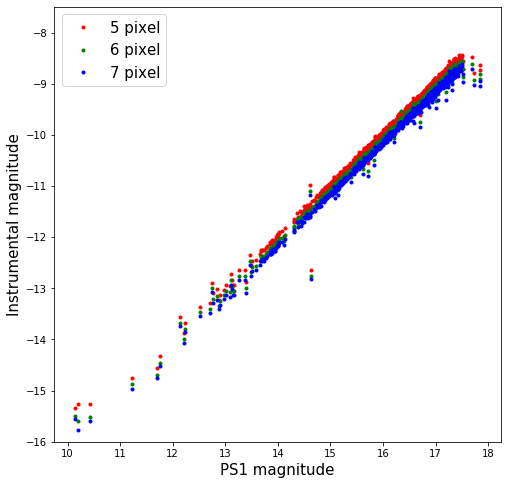

In [17]:
plt.figure(figsize=(8,8))
#5.0、6.0、および7.0ピクセルの開口サイズの測定等級のプロット
plt.plot(good_cat_stars['gmag'][idx_ps1], cleanSources['MAG_APER'][:,2][idx_image] , 'r.', label='5 pixel')
plt.plot(good_cat_stars['gmag'][idx_ps1], cleanSources['MAG_APER'][:,3][idx_image] , 'g.', label='6 pixel')
plt.plot(good_cat_stars['gmag'][idx_ps1], cleanSources['MAG_APER'][:,4][idx_image] , 'b.', label='7 pixel')
plt.ylim(-16, -7.5)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental magnitude', fontsize=15)
plt.legend(fontsize=15)
plt.show()

　これは、PS1と測定等級間の良好な相関関係であり、異なる開口サイズの等級間の小さな系統的なオフセットも示しています。
 
　これで、各開口部のゼロ点を取得する準備が整いました。先程の式の通り、ゼロ点はカタログと測定等級の違いなので、測光に影響を与える可能性のある外れ値を排除した上で、これらの等級間の平均オフセットを測定する必要があります。その結果は、ゼロ点の平均値、中央値、標準偏差を含む辞書型に保存されます。

In [18]:
zeroPoints = []
for i in range(len(aperture_diameter)):
    #カタログと測定等級の違いを表す配列
    offsets = ma.array(good_cat_stars['gmag'][idx_ps1] - cleanSources['MAG_APER'][:,i][idx_image])
    #シグマクリップ統計の計算
    zero_mean, zero_med, zero_std = sigma_clipped_stats(offsets)
    zeroDict = {'diameter': aperture_diameter[i], 'zp_mean': zero_mean, 'zp_median': zero_med, 'zp_std': zero_std}
    zeroPoints.append(zeroDict)
    print(zeroDict)

{'diameter': 4, 'zp_mean': 25.49013640741123, 'zp_median': 25.488113817596435, 'zp_std': 0.036529631772000574}
{'diameter': 5, 'zp_mean': 25.775105347043027, 'zp_median': 25.77419780578613, 'zp_std': 0.035339556182328785}
{'diameter': 6, 'zp_mean': 25.957074592276147, 'zp_median': 25.956391754150392, 'zp_std': 0.03510991994317378}
{'diameter': 7, 'zp_mean': 26.075167255174705, 'zp_median': 26.076413306427003, 'zp_std': 0.03660146731678471}
{'diameter': 8, 'zp_mean': 26.151855657309714, 'zp_median': 26.153427323913576, 'zp_std': 0.03878513940933749}
{'diameter': 9, 'zp_mean': 26.20309040569061, 'zp_median': 26.20499310302734, 'zp_std': 0.0419986053640713}
{'diameter': 10, 'zp_mean': 26.237357219375856, 'zp_median': 26.239008388519288, 'zp_std': 0.04659602723581701}
{'diameter': 11, 'zp_mean': 26.26119270003653, 'zp_median': 26.262815995788575, 'zp_std': 0.050839020837056936}
{'diameter': 12, 'zp_mean': 26.277082248535184, 'zp_median': 26.279197425842284, 'zp_std': 0.054368917650005524}


　見ての通り、ゼロ点は開口部のサイズによって変化します。したがって、正しい測光を行うためには、開口部のフラックスを測定し、同じ開口部にゼロ点補正を適用する必要があります。この開口部の補正は、__アパーチャー補正__ と呼ばれます。

　それぞれのゼロ点補正を適用し、測定された等級の不確実性と直角位相のゼロ点の不確実性を追加することで不確実性を計算します。そこでphotutilsと呼ばれる測光用のastropyに基づいたパッケージを使用します。photutilsには、画像の測光を実行するために便利なツールが多数含まれています。

In [19]:
from astropy import units as u
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

ra = 324.7915750
dec = 46.7254686
#天球座標でターゲットの位置を指定します
position = SkyCoord(ra = ra, dec = dec, unit = u.deg, frame = 'icrs')
#次に、フラックスを測定するための開口部のセットアップをします
aperture_radii = np.array([4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]) / 2 #ピクセル単位の開口半径 
apertures = [SkyCircularAperture(position, r = r * u.pix) for r in aperture_radii]
#開口部を天球座標からピクセル座標に変換します
pix_apertures = [a.to_pixel(w) for a in apertures]
#次に、これらの開口部内のフラックスをdataから計算します
phot_table = aperture_photometry(data, pix_apertures)
#出力を使用可能な形式に変換します
for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'    
#結果を出力します
print(phot_table)

 id  xcenter   ycenter  ... aperture_sum_7 aperture_sum_8 aperture_sum_9
       pix       pix    ...                                             
--- --------- --------- ... -------------- -------------- --------------
  1 2005.1641 2013.4913 ...      29371.792      29346.605      29142.183


　これまでは、画像上の一連の固定サイズの円形開口部内のフラックスを測定しました。次に、天体の周りのバックグラウンドを計算する必要があるので、天体周りの環状のフラックスを測定します。半径10.0ピクセル、幅10.0ピクセルの環のバックグラウンドを測定します。

In [20]:
#環状の開口部を作成する
anuRadius = 10.0
anuWidth = 10.0
annulus_aperture = SkyCircularAnnulus(position, r_in = anuRadius * u.pix, r_out = (anuRadius + anuWidth) * u.pix)
pix_annulus_aperture = annulus_aperture.to_pixel(w)
#開口環の内側のフラックスを測定する
annulus_phot_table = aperture_photometry(data, pix_annulus_aperture)
for col in annulus_phot_table.colnames:
        annulus_phot_table[col].info.format = '%.8g'    
#結果を出力します
print(annulus_phot_table)

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 2005.1641 2013.4913   -29101.272


　これで、測定されたフラックスからバックグラウンドのフラックスを差し引くことで、天体のフラックスを測定する準備ができました。

In [27]:
#単位ピクセル領域あたりのバックグラウンドのフラックスを推定する
bkg_mean = annulus_phot_table['aperture_sum'] / pix_annulus_aperture.area
for i in range(len(pix_apertures)):
    #この特定の開口サイズのバックグラウンドフラックスを推定する
    bkg_flux = bkg_mean * pix_apertures[i].area
    #元のフラックスからこのバックグラウンドフラックスを差し引きます
    source_flux = phot_table['aperture_sum_%d'%i] - bkg_flux
    source_mag = zeroPoints[i]['zp_median'] - 2.5 * np.log10(source_flux)
    print('Found source magnitude of %.2f for aperture of radius %d pixels'%(source_mag, aperture_radii[i]))

Found source magnitude of 15.07 for aperture of radius 2 pixels
Found source magnitude of 15.05 for aperture of radius 2 pixels
Found source magnitude of 15.02 for aperture of radius 3 pixels
Found source magnitude of 15.02 for aperture of radius 3 pixels
Found source magnitude of 15.00 for aperture of radius 4 pixels
Found source magnitude of 15.00 for aperture of radius 4 pixels
Found source magnitude of 14.99 for aperture of radius 5 pixels
Found source magnitude of 14.99 for aperture of radius 5 pixels
Found source magnitude of 14.99 for aperture of radius 6 pixels
Found source magnitude of 14.99 for aperture of radius 6 pixels


__Question__:ピクセルのノイズがポアソン分布に従うと仮定して、この測定の統計誤差を推定する方法を考えましょう。また、画像は通常ADU（デジタル単位）の単位で記録されますが、ポアソンノイズは電子数にのみ適用されることを思い出してください。ADUをどのようにして電子数に変換しますか？

　開口部の等級は、測定の誤差内で互いに完全に一致していることに注意してください（天体の物理的な等級は、フラックスの測定に使用した開口部に依存するべきではありません）。これはアパーチャー補正がうまく機能していることを示唆しています。また、バックグラウンドからのノイズが多く蓄積されるため、大きな開口部ではエラーが徐々に大きくなることにも注意してください。
 
__Question__ :この天体の開口測光から得られる等級を別の方法で測定する方法はないでしょうか？SExtractorのカタログに何が含まれていたか考えてみてください。SExtractorのカタログから天体の等級をどのように抽出しますか？

## PSF測光

　開口測光はかなり簡単で、比較的分離された天体に適しています（開口部またはバックグラウンドに他の天体はありません）。ただし、これは天体が集中しているフィールド（銀河面など）の場合には当てはまらない可能性があり、他の天体と重ならない開口部を見つけるのが困難な場合があります。そこでPSF測光を使います。

### PSFモデルの作成

　PSF測光の考え方は、多数の星をフィッティングすることにより、フィールド内の星の点像分布関数のモデルを作成することです。次に、モデルはデータから繰り返し減算され、残差を最小限に抑えるように調整されます。現在使用されているPSF測光のパッケージは数多くあり、手動の関与と自動化の度合いはさまざまです。この講座では、PSFExと呼ばれるパッケージを使用します。これもAstromatic.netのコードの1つです。
 
　PSFExはSExtractorカタログを入力値として受け取ります。カタログはFITS LDAC形式であり、モデルフィッティングを実行するフィールドで検出された星のカットアウトが含まれている必要があります。この講座では、SExtractorを初めて実行したときにすでに星のカットアウトを作成しました。「PARAMETERS_NAME」ファイルには、各天体の周りのカットアウトのサイズを指定するVIGNETという項目がありました。次に、このカタログでPSFExを実行し、画像のPSFモデルを作成します。PSFExのランタイムパラメーターを指定した「psfex_conf.psfex」と呼ばれる入力構成ファイルがあります。

In [28]:
psfConfigFile = 'psfex_conf.psfex'
try:
    command = 'psfex -c %s %s' % (psfConfigFile, catalogName)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

Executing command: psfex -c psfex_conf.psfex aC0_20181013-174714-557.wcs.fits.proc.cr.fits.cat


　PSFExによって生成されたPSFモデルをプロットします。最適なMoffatモデルは、FITSファイルとして出力画像 'moffat_' + imageName + '.fits'に保存されます。

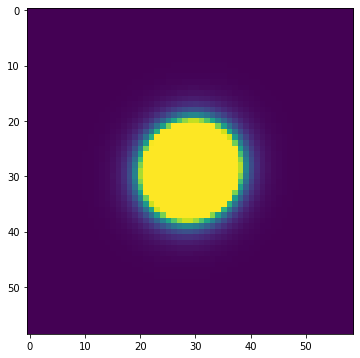

In [30]:
psfModelHDU = fits.open('moffat_'+imageName+'.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)
plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std)
plt.show()

　また、最適なPSFモデルの放射状プロファイルを確認することも大切です。放射状プロファイルを作成してプロットしてみましょう。

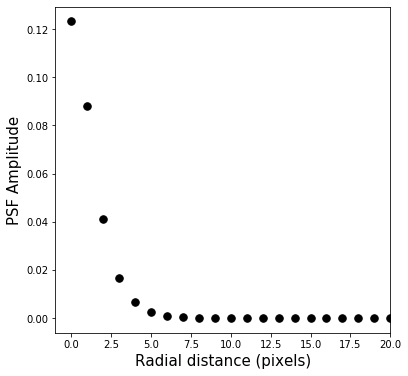

In [31]:
psfImageCenter = [(psfModelData.shape[0]-1)/2, (psfModelData.shape[1]-1)/2]
y, x = np.indices(psfModelData.shape)
r = np.sqrt((x-psfImageCenter[0])**2 + (y-psfImageCenter[1])**2)
r = r.astype(np.int)

tbin = np.bincount(r.ravel(), psfModelData.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin/nr

plt.figure(figsize=(6,6))
plt.plot(range(len(radialprofile)), radialprofile, 'k.', markersize=15)
plt.xlabel('Radial distance (pixels)', fontsize=15)
plt.ylabel('PSF Amplitude', fontsize=15)
plt.xlim(-1,20)
plt.show()

__Question__:上記のコードがPSFの放射状プロファイルを生成できる理由を理解しましょう。

### 点光源のPSFフィット測光の計算

　これで、このPSFモデルをSExtractorにフィードバックして、検出された各天体に対してPSFモデルフィッティングを実行し、各天体のPSFフィットフラックスを生成することができます。PSFモデルは、imageName + '.psf'というファイルに保存されます。これは、計算機の速度によっては少し時間がかかる場合があります。

In [32]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' #これは、PSFフィットでの等級を含む、SExtractorから取得される新しいパラメーターのセットです。
try:
    #PSF_NAMEオプション付きのPSFモデルをSExtactorに提供しています
    command = 'sextractor -c %s %s -CATALOG_NAME %s -PSF_NAME %s -PARAMETERS_NAME %s' % (configFile, imageName, psfcatalogName, psfName, psfparamName)
    print("Executing command: %s" % command)
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print('Could not run sextractor with exit error %s'%err)

Executing command: sextractor -c photomCat.sex aC0_20181013-174714-557.wcs.fits.proc.cr.fits -CATALOG_NAME aC0_20181013-174714-557.wcs.fits.proc.cr.fits.psf.cat -PSF_NAME aC0_20181013-174714-557.wcs.fits.proc.cr.fits.psf -PARAMETERS_NAME photomPSF.param


　前回と同じように新しいPSFフィットSExtractorカタログを読んで、その内容を確認してみましょう。「MAG_POINTSOURCE」や「MAGERR_POINTSOURCE」など、追加された新しい列が見つかると思います。これらは、SExtractorで測定された新しいPSFモデルフィットの等級です。

In [33]:
psfsourceTable = get_table_from_ldac(psfcatalogName)
#テーブルの内容を見てみましょう
print(psfsourceTable.colnames)
print(psfsourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
       VIGNET [27,27]          X_IMAGE   ... FLUXRATIOERR_POINTSOURCE
             ct                  pix     ...                         
---------------------------- ----------- ... ------------------------
    6.422684 ..     23.85748   1701.0402 ...                  0.00000
   -5.962967 ..    -12.01412    900.8122 ...                  0.00000
    -67.4418 ..    -68.55728   3444.9138 ...                  0.00000
   -81.50293 ..    -73.63473    308.4576 ...                  0.00000
   0.7086449 ..      

　これで、開口測光と同じ行程を行う準備ができました。PSFフィッティングされた等級に基づいて画像のゼロ点を計算します。'XMODEL_IMAGE'および 'YMODEL_IMAGE'は、PSFフィッティングに基づく星の重心です。「FLAGS_MODEL」列を使用して、PSFフィッティング測光がうまく機能しなかった天体を見つけることができます（良好な天体の場合、フラグは0になるように設定されています）。良好なPSFフィット天体とPS1カタログの間のクロスマッチングを行います。

In [34]:
#開口測光と同様に画像のエッジから離れた天体を選択する
cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

### カタログのクロスマッチング

　開口測光と同じように、良好なPSFフィット天体とPS1カタログの間でクロスマッチングを実行します。

In [35]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
#クロスマッチングを行います
#クロスマッチ距離のしきい値を0.6秒または約1ピクセルに設定します
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print('Found %d good cross-matches'%len(idx_psfimage))

Found 748 good cross-matches


　次に、一致した天体のPS1等級に対するPSFフィット等級の散布図を作成します

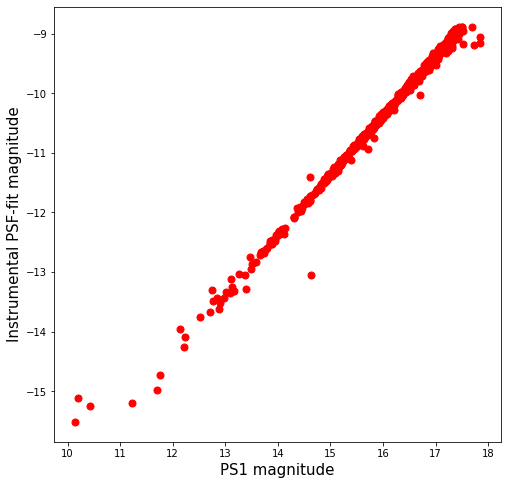

In [36]:
plt.figure(figsize=(8,8))
#5.0、6.0、および7.0ピクセルの開口サイズの測定等級のプロット
plt.plot(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage] , 'r.', markersize=14)
#plt.ylim(-16, -7.5)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

### ゼロ点の導出

　PSFフィット等級のプロットが明るいほど直線から外れていることに注意してください。これは、PSFが非常に明るい星の基で飽和状態になり始め、PSFの適合が悪くなるためです。ゼロ点を導出するために3シグマクリッピングを実行すると、これらは自動的に取り除かれます。開口測光の場合と同様に、PSFフィットとPS1等級間のオフセットをシグマクリッピングすることにより、PSF測光のゼロ点を計算します。

In [37]:
psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
#シグマクリップ統計を計算します
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

PSF Mean ZP: 26.37
PSF Median ZP: 26.37
PSF STD ZP: 0.04


　目標天体のPSFフィット等級を取得するために、テーブル座標を天体の座標にクロスマッチングすることにより、天体の座標のSExtractorのPSFフィット測光テーブルを直接読み取ることができます。

In [38]:
ra = 324.7915750
dec = 46.7254686

v641cyg_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_v641cyg, idx_cleanpsf_v641cyg, d2d, d3d = psfsourceCatCoords.search_around_sky(v641cyg_coords, photoDistThresh*u.arcsec)
print('Found the source at index %d'%idx_cleanpsf_v641cyg[0])

Found the source at index 1052


　次に、SExtractorカタログから天体のPSFフィット等級を取得し、結果を出力します。

In [39]:
v641cyg_psfinstmag = cleanPSFSources[idx_cleanpsf_v641cyg]['MAG_POINTSOURCE'][0]
v641cyg_psfinstmagerr = cleanPSFSources[idx_cleanpsf_v641cyg]['MAGERR_POINTSOURCE'][0]

v641cyg_psfmag = zero_psfmed + v641cyg_psfinstmag
v641cyg_psfmagerr = np.sqrt(v641cyg_psfinstmagerr**2 + zero_psfstd**2)

print('PSF-fit magnitude of V641 Cyg is %.2f +/- %.2f'%(v641cyg_psfmag, v641cyg_psfmagerr))

PSF-fit magnitude of V641 Cyg is 14.98 +/- 0.04


　アパーチャー補正した等級とPSFフィット等級は互いに一致している必要があります。